# Park Visitation and Meteorological Relationships
a. stein 3.10.22

Examine relationships and potential for correlation between park visitation data and meteorological data, (currently precipitation, max air temperature, minimum air temperature).

In [51]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as cx

import rioxarray
from shapely.geometry import mapping

import sys
sys.path.append('../../')
import sedi.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load in Park Data

In [2]:
park_path = '/pool0/home/steinadi/data/drought/drought_impact/data/socio-econ'

nat_park_visits = xr.open_dataset(f'{park_path}/national_parks_or_wa.nc')

Need to real quick get rid of that one park in Alaska

nat_parks = list(nat_park_visits.park.values)
del nat_parks[2]
nat_parks

nat_park_visits.sel(park=nat_parks).to_netcdf(f'{park_path}/national_parks_or_wa.nc')

In [3]:
nat_parks = nat_park_visits.park.values

In [4]:
nat_parks

array(['Crater Lake', 'John Day Fossil Beds National Monument',
       'Lake Chelan National Recreation Area',
       'Lake Roosevelt National Recreation Area',
       'Lewis and Clark National Historic Place',
       'Mount Rainer National Park', 'North Cascades National Park',
       'Olympic National Park',
       'Oregon Caves National Park and National Monument',
       'Ross Lake National Recreation Area',
       'San Juan Island National Historic Park'], dtype=object)

In [15]:
geo_path = '/pool0/home/steinadi/data/drought/drought_impact/data/geometry'

nps_gdf = gpd.read_file(f'{geo_path}/pw_nps_select_geo.geojson')

In [16]:
# Check this real quick
#nps_gdf
# good, the geometry is in the same order as the parks in the netcdf, that'll make life easier

# check crs ...
nps_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Get met data

In [27]:
met_path = '/pool0/home/steinadi/data/drought/drought_impact/data/met'

precip = xr.open_dataset(f'{met_path}/precip/wa_or_precip_1979_2022.nc')
precip_var = 'precipitation_amount'
tmax = xr.open_dataset(f'{met_path}/tair_max/wa_or_tair_max_1979_2022.nc')
tmin = xr.open_dataset(f'{met_path}/tair_min/wa_or_tair_min_1979_2022.nc')
tair_var = 'air_temperature'

Let's make a timeseries for one of the parks then with some of this met data.

I'm going to start with Crater Lake, the first entry.

In [25]:
precip[precip_var]

<xarray.DataArray 'precipitation_amount' (day: 15766, lat: 169, lon: 199)>
[530226346 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 42.11 42.07 42.03 41.98
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -116.6 -116.5 -116.5
  * day      (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-01
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    grid_mapping:       crs

Ah, they lost their crs writing in the process ... let's fix that

In [31]:
met_crs = 'EPSG:4326'

precip_da = precip[precip_var].rio.write_crs(met_crs)
tmax_da = tmax[tair_var].rio.write_crs(met_crs)
tmin_da = tmin[tair_var].rio.write_crs(met_crs)

In [42]:
crater_lake_gdf = nps_gdf[nps_gdf.UNIT_CODE == 'CRLA']
crater_lake_gdf

,OBJECTID,UNIT_CODE,GIS_Notes,UNIT_NAME,DATE_EDIT,STATE,REGION,GNIS_ID,UNIT_TYPE,CREATED_BY,METADATA,PARKNAME,CreationDate,Creator,EditDate,Editor,GlobalID,Shape__Area,Shape__Length,geometry
0,81,CRLA,Lands - http://landsnet.nps.gov/tractsnet/docu...,Crater Lake National Park,1496620800000,OR,PW,1163670,National Park,Lands,https://irma.nps.gov/DataStore/Reference/Profi...,Crater Lake,1641465752000,WASO,1641465752000,WASO,a804733f-87a4-4e56-95f5-84e51179e5e0,1.382854e+09,175437.474148,"MULTIPOLYGON (((-122.88278 42.33695, -122.8828..."


In [43]:
crater_lake_precip = wrangle.clip_xarray(precip_da, crater_lake_gdf)

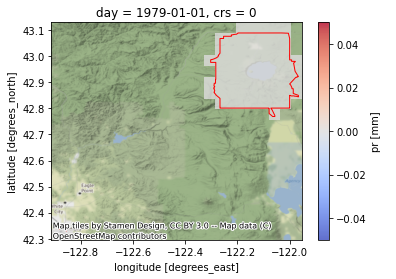

In [58]:
fig, ax = plt.subplots()

crater_lake_precip.isel(day=0).plot(ax=ax, cmap = 'coolwarm', alpha=0.8)
crater_lake_gdf.plot(ax=ax, facecolor='none', edgecolor='r')
cx.add_basemap(ax, crs=met_crs)

That looks effective ... might need to fixt that geometry for including some weird blip on the bottom left ...

Let's go for a timeseries ...

In [67]:
crater_lake_mean_precip = crater_lake_precip.mean(dim=['lat','lon'])

Text(0, 0.5, 'Date')

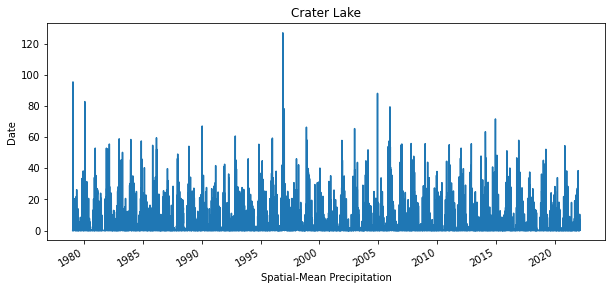

In [71]:
fig, ax = plt.subplots(figsize=(10,4))
crater_lake_mean_precip.plot(ax=ax)
ax.set_title('Crater Lake')
ax.set_xlabel('Spatial-Mean Precipitation')
ax.set_ylabel('Date')

That's promising ... what if I turn it into total monthly precip?

In [79]:
crater_lake_mean_precip_monthly_sum = crater_lake_mean_precip.resample(day='M').sum()

Text(0.5, 1.0, 'Crater Lake')

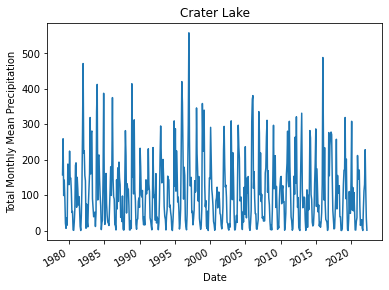

In [82]:
fig, ax = plt.subplots()
crater_lake_mean_precip_monthly_sum.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Total Monthly Mean Precipitation')
ax.set_title('Crater Lake')